In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_state_qsphere
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import *

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output


import warnings
warnings.simplefilter('ignore')

import random
import time

random.seed(69069)
np.random.seed(69069)

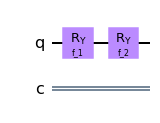

In [2]:
circuit = QuantumCircuit(1,1)
circuit.ry(Parameter('f_1'), 0)
circuit.ry(Parameter('f_2'), 0)
circuit.draw('mpl')

In [3]:
#Features to resemble a XOR
features = [[0,0],
            [0,1],
            [1,0],
            [1,1]]

targets = [0,
          1,
          1,
          0]

In [4]:
#code to normalize weights to a range of -1 and 1
from sklearn.preprocessing import MinMaxScaler

def normalize_data(data):
    return MinMaxScaler().fit_transform(data) * 2 - 1

normalized_features = normalize_data(features)
print(normalized_features)

[[-1. -1.]
 [-1.  1.]
 [ 1. -1.]
 [ 1.  1.]]


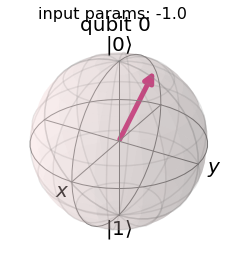

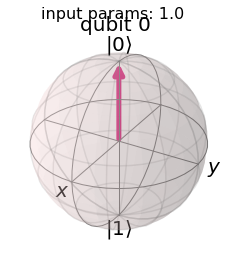

In [5]:
#If we add the parameters as is into the circuit, we get the following qubit states:
qc = QuantumCircuit(1)
for param in normalized_features[1]:
    qc.ry(param,0)
    state = Statevector.from_instruction(qc)
    display(plot_bloch_multivector(state, title="input params: " + str(param), reverse_bits=False))


In [6]:
#As we can see, they cancel eachother out. The goal is now to train 2 weights that
#will make it so that we get a good representation of the target state, as goes by XOR rules

In [7]:
def fit_and_score(circuit_classifier, features, targets):
    plt.rcParams["figure.figsize"] = (12, 6)

    start_time = time.time()
    # fit classifier to data
    circuit_classifier.fit(features, targets)
    runtime = time.time() - start_time

    # return to default figsize
    plt.rcParams["figure.figsize"] = (6, 4)

    # score classifier
    score =  circuit_classifier.score(features, targets)
    print('Score: ' + str(score))
    return score, runtime
    

In [8]:
# parity maps bitstrings to 0 or 1
output_shape = 1  # corresponds to the number of classes, possible outcomes of the (parity) mapping.
def parity(x):
    return '{:b}'.format(x).count('1') % output_shape


In [9]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

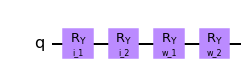

No interpret function given, output_shape will be automatically determined as 2^num_qubits.


In [10]:
quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator'), shots=1024)
# construct QNN

feature_map = QuantumCircuit(1)
feature_map.ry(Parameter('i_1'),0)
feature_map.ry(Parameter('i_2'),0)

ansatz = QuantumCircuit(1)
ansatz.ry(Parameter('w_1'),0)
ansatz.ry(Parameter('w_2'),0)

qc = QuantumCircuit(1)
qc.append(feature_map, range(1))
qc.append(ansatz, range(1))
display(qc.decompose().draw('mpl'))

circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         #interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

In [11]:
# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

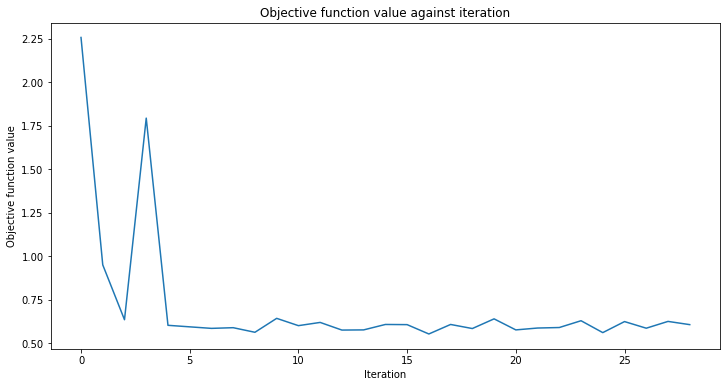

Score: 1.0


(1.0, 6.673685073852539)

In [12]:
#change data parameters
normalized_features = np.array(normalized_features)
targets = np.array(targets)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
fit_and_score(circuit_classifier, normalized_features, targets)


In [13]:
#As we can see we achieve perfect accuracy. 
#Apparently it seems to work, but what about a more complex dataset?
#One with 3 classes?
#Que in IRIS for the n-th fucking time
stats = []

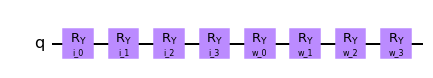

In [14]:
from sklearn.datasets import load_iris

#we need to update the parity function to resemble 3 classes
# parity maps bitstrings to 0 or 1
output_shape = 3  # corresponds to the number of classes, possible outcomes of the (parity) mapping.
def parity(x):
    return '{:b}'.format(x).count('1') % output_shape

# Load the data and split it up into usable chunks
dataset = load_iris()
data = dataset['data']
targets = np.array(dataset['target'])

normalized_features = np.array(normalize_data(data))

feature_map = QuantumCircuit(1)
ansatz = QuantumCircuit(1)
for i in range(len(normalized_features[1])):
    feature_map.ry(Parameter('i_' + str(i)),0)
    ansatz.ry(Parameter('w_' + str(i)),0)



qc = QuantumCircuit(1)
qc.append(feature_map, range(1))
qc.append(ansatz, range(1))
display(qc.decompose().draw('mpl'))

circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)



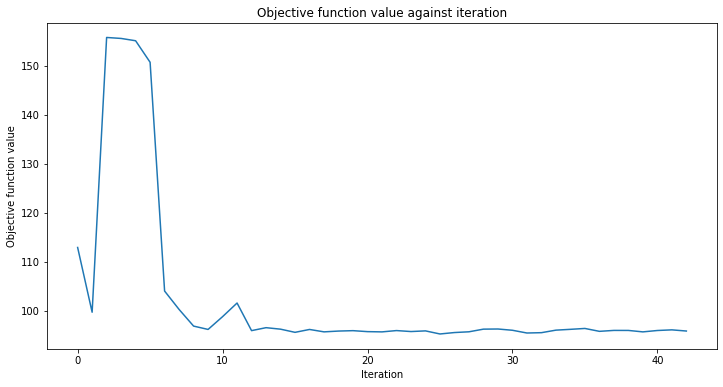

Score: 0.58


In [15]:
# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)
complexity = qc.decompose().width() * qc.decompose().depth()

stats.append([runtime, score, complexity])

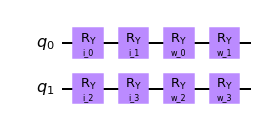

In [16]:
#okay, the accuracy is okay for a first try with 0.55. What if we split up the inputs and weights onto two? qubits?
feature_map = QuantumCircuit(2)
ansatz = QuantumCircuit(2)
for i in range(int(len(normalized_features[1])/2)):
    feature_map.ry(Parameter('i_' + str(i)),0)
    feature_map.ry(Parameter('i_' + str(i+2)),1)
    ansatz.ry(Parameter('w_' + str(i)),0)
    ansatz.ry(Parameter('w_' + str(i+2)),1)



qc = QuantumCircuit(2)
qc.append(feature_map, range(2))
qc.append(ansatz, range(2))
display(qc.decompose().draw('mpl'))

circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)




# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
#fit_and_score(circuit_classifier, normalized_features, targets)  

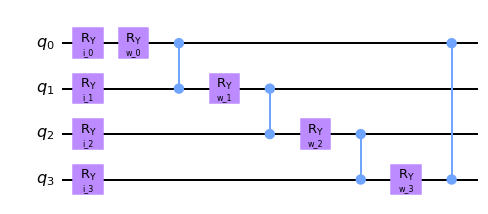

In [17]:
#okay, the accuracy is okay for a first try with 0.55. What if we split up the inputs and weights onto two? qubits?

#we need to update the parity function to resemble 3 classes
# parity maps bitstrings to 0 or 1
output_shape = 3  # corresponds to the number of classes, possible outcomes of the (parity) mapping.
def parity(x):
    return '{:b}'.format(x).count('1') % output_shape


feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(normalized_features[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)
    ansatz.cz(i, (i+1)%4)


qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))

circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

display(qc.decompose().draw('mpl'))

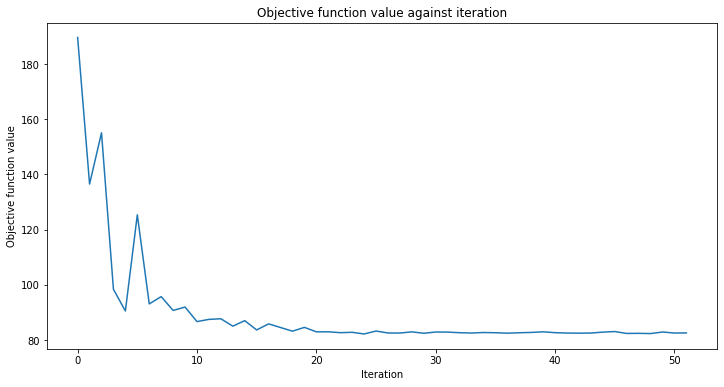

Score: 0.9


In [18]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)
complexity = qc.decompose().width() * qc.decompose().depth()

stats.append([runtime, score, complexity])

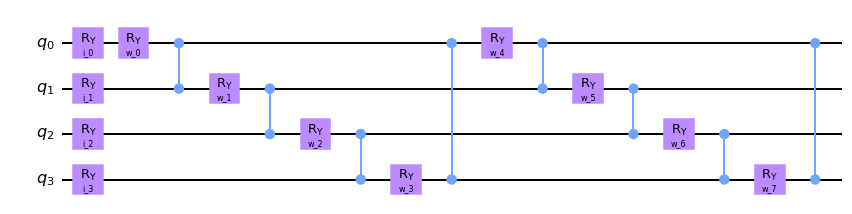

In [19]:
feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(normalized_features[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)

for i in range(len(normalized_features[0])*2):
    ansatz.ry(Parameter('w_' + str(i)),i%4)
    ansatz.cz(i%4, (i+1)%4)


qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))

circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

display(qc.decompose().draw('mpl'))


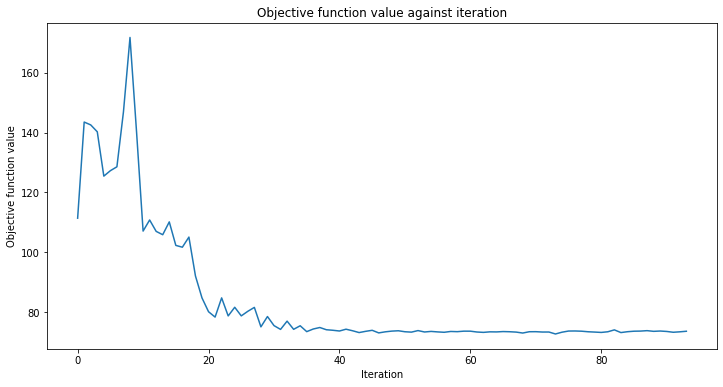

Score: 0.6933333333333334


In [20]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)
complexity = qc.decompose().width() * qc.decompose().depth()

stats.append([runtime, score, complexity]) 

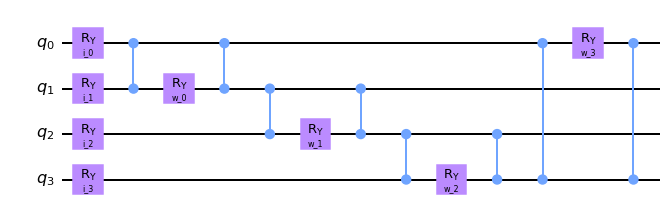

In [21]:
feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(normalized_features[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)

for i in range(len(normalized_features[0])):
    ansatz.cz(i%4, (i+1)%4)
    ansatz.ry(Parameter('w_' + str(i)),(i+1)%4)
    ansatz.cz(i%4, (i+1)%4)


qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))

circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

display(qc.decompose().draw('mpl'))

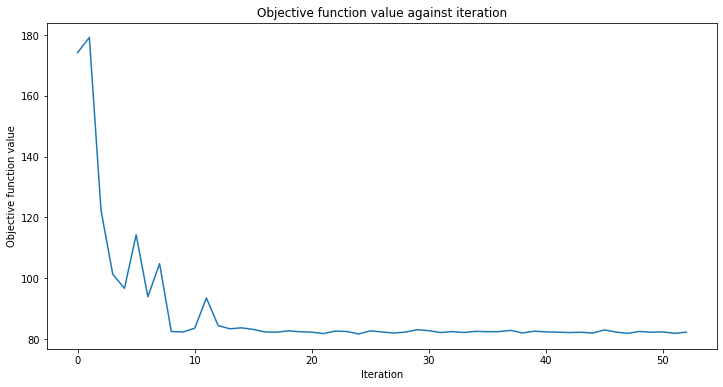

Score: 0.78


In [22]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)
complexity = qc.decompose().width() * qc.decompose().depth()

stats.append([runtime, score, complexity]) 

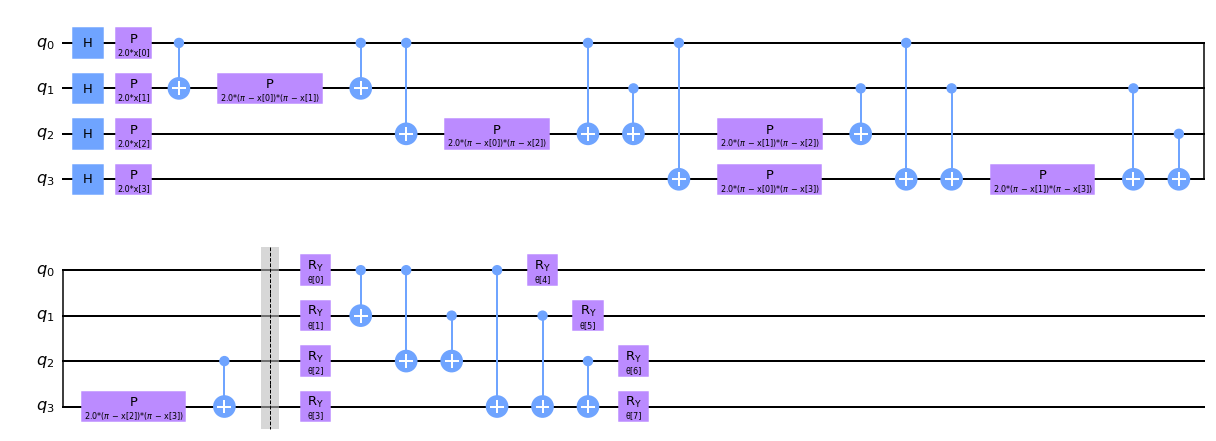

In [23]:
n_inputs = len(normalized_features[0])

# construct feature map
feature_map = ZZFeatureMap(n_inputs, reps=1)

# construct ansatz
ansatz = RealAmplitudes(n_inputs, reps=1)

# construct quantum circuit
qc = QuantumCircuit(n_inputs)
qc.append(feature_map, range(n_inputs))
qc.barrier()
qc.append(ansatz, range(n_inputs))
display(qc.decompose().decompose().draw(output='mpl'))


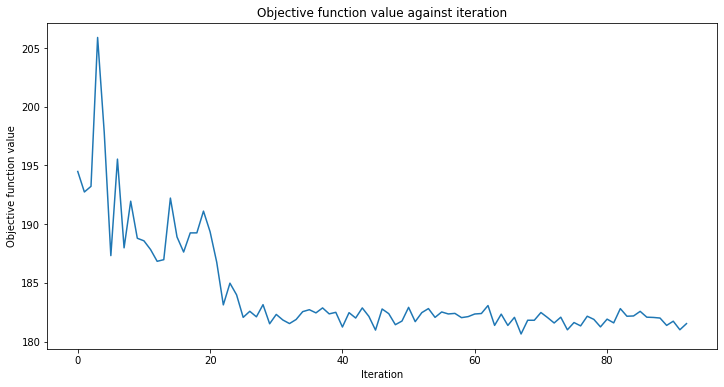

Score: 0.4533333333333333


In [24]:
# construct QNN
circuit_qnn = CircuitQNN(circuit=qc,
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)
complexity = qc.decompose().width() * qc.decompose().depth()

stats.append([runtime, score, complexity]) 

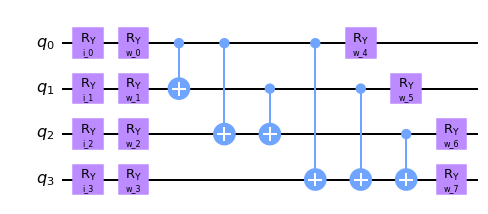

In [25]:
feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(normalized_features[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)

for i in range(len(normalized_features[0])):
    ansatz.ry(Parameter('w_' + str(i)), i)

ansatz.cx(0,1)
ansatz.cx(0,2)
ansatz.cx(0,3)
ansatz.cx(1,2)
ansatz.cx(1,3)
ansatz.cx(2,3)

for i in range(len(normalized_features[0])):
    ansatz.ry(Parameter('w_' + str(i+4)), i)

qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))

circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

display(qc.decompose().draw('mpl'))

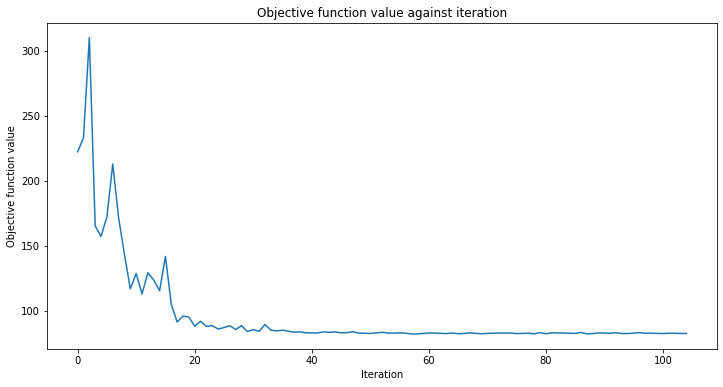

Score: 0.5866666666666667


In [26]:
#create empty array for callback to store evaluations of the objective function
objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)
complexity = qc.decompose().width() * qc.decompose().depth()

stats.append([runtime, score, complexity])  

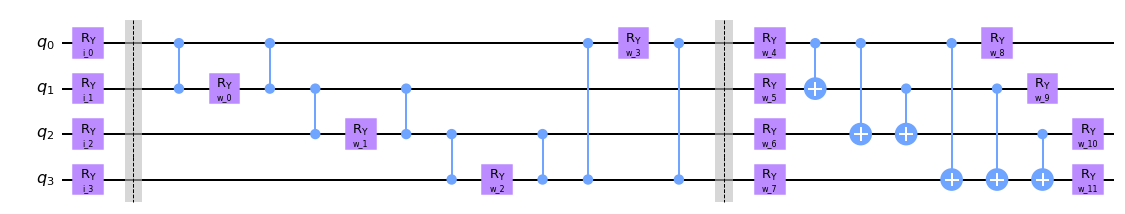

In [27]:
feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(normalized_features[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)

for i in range(len(normalized_features[0])):
    ansatz.cz(i%4, (i+1)%4)
    ansatz.ry(Parameter('w_' + str(i)),(i+1)%4)
    ansatz.cz(i%4, (i+1)%4)

ansatz.barrier()

for i in range(len(normalized_features[0])):
    ansatz.ry(Parameter('w_' + str(i+4)), i)

ansatz.cx(0,1)
ansatz.cx(0,2)
ansatz.cx(0,3)
ansatz.cx(1,2)
ansatz.cx(1,3)
ansatz.cx(2,3)

for i in range(len(normalized_features[0])):
    ansatz.ry(Parameter('w_' + str(i+8)), i)

qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.barrier()
qc.append(ansatz, range(4))

circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

display(qc.decompose().draw('mpl'))



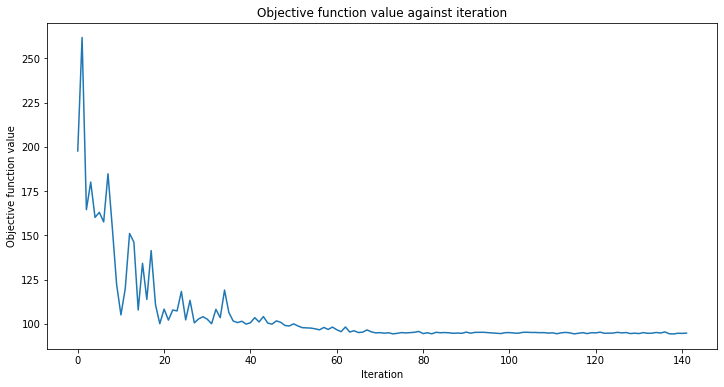

Score: 0.38


In [28]:
#create empty array for callback to store evaluations of the objective function
objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)
complexity = qc.decompose().width() * qc.decompose().depth()

stats.append([runtime, score, complexity]) 

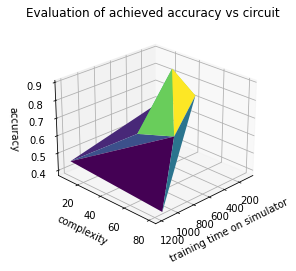

In [36]:
#Creating comparison of all circuits that use the full IRIS dataset:

stats = np.array(stats)

x, z, y = stats.reshape(-1,3).T

#z = np.array([[i] for i in z])

fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.plot_trisurf(x,y,z, cmap='viridis', linewidth=1)
ax.set_title('Evaluation of achieved accuracy vs circuit')
ax.set_xlabel('training time on simulator')
ax.set_ylabel('complexity')
ax.set_zlabel('accuracy')
ax.view_init(25, 45)

plt.show()


<BarContainer object of 7 artists>

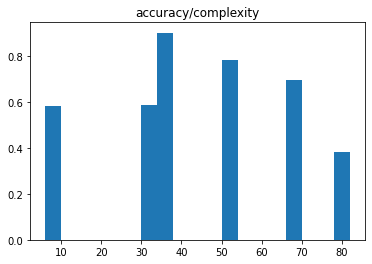

In [64]:
fig = plt.figure()
ax = plt.axes()
ax.set_title('accuracy/complexity')
ax.bar(y,z, width = 4)

<BarContainer object of 7 artists>

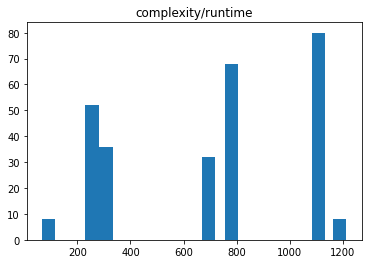

In [65]:
fig = plt.figure()
ax = plt.axes()
ax.set_title('complexity/runtime')
ax.bar(x,y, width = 50)

<BarContainer object of 7 artists>

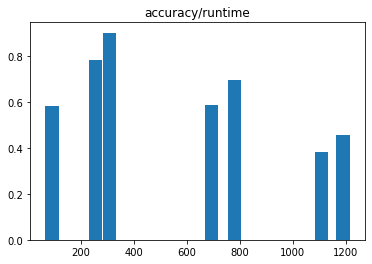

In [67]:
fig = plt.figure()
ax = plt.axes()
ax.set_title('accuracy/runtime')
ax.bar(x,z, width = 50)

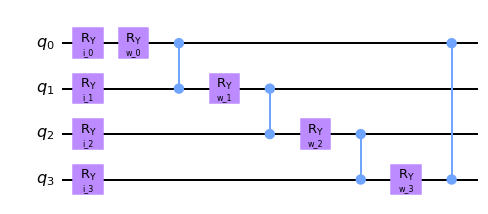

In [84]:

feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(normalized_features[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)
    ansatz.cz(i, (i+1)%4)


qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))

circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph,
                                             warm_start=True)

display(qc.decompose().draw('mpl'))

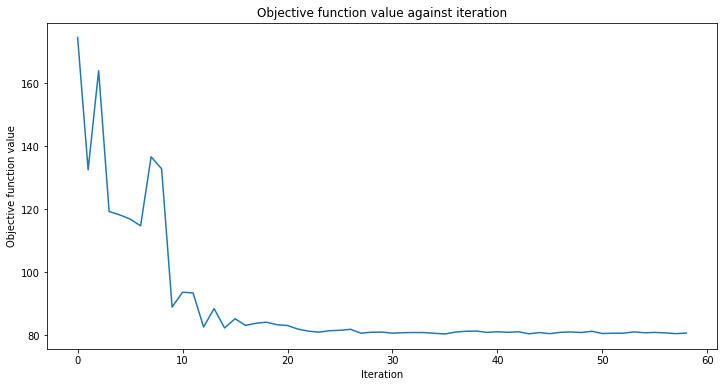

Score: 0.84


In [85]:
#create empty array for callback to store evaluations of the objective function
objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)
complexity = qc.decompose().width() * qc.decompose().depth()

#stats.append([runtime, score, complexity]) 

In [86]:
fit_and_score(circuit_classifier, normalized_features, targets)

TypeError: 'bool' object is not callable